# Import Libraries

In [40]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualizations
import os
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
# Helper fuctions to evaluate our model.
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix 

# Dataset Loading
read the dataset using the first 10 million rows

In [2]:
df = pd.read_csv('../data/2019-Nov.csv', nrows = 10000000)
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


### Data types

In [3]:
df.dtypes

event_time        object
event_type        object
product_id         int64
category_id        int64
category_code     object
brand             object
price            float64
user_id            int64
user_session      object
dtype: object

# Data Cleaning 

### Drop Duplicate Values and columns of no use

In [4]:
# check for deplicate rows
df.duplicated().sum()

print(df.shape, 'before dropping duplicates')

# drop duplicates rows
df = df.drop_duplicates()

print(df.shape, 'after dropping duplicates')

(10000000, 9) before dropping duplicates
(9996291, 9) after dropping duplicates


# Customer behavior

## Top 10 brand that most customer purchased vs. view

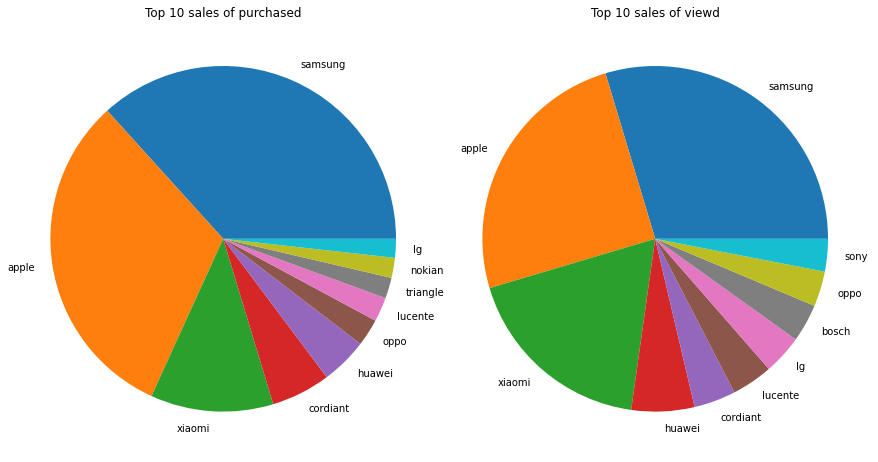

In [5]:
# most customer purchased
purchased = df.loc[df.event_type == 'purchase']
purchases_with_brands = purchased.loc[purchased.brand.notnull()]

purchased_top_sellers = purchases_with_brands.groupby('brand').brand.agg([len]).sort_values(by="len", ascending=False)
purchased_top_sellers.reset_index(inplace=True)
purchased_top_sellers.rename(columns={"len" : "# sales"}, inplace=True)

# most customer view
view = df.loc[df.event_type == 'view']
view_with_brands = view.loc[view.brand.notnull()]

view_top_sellers = view_with_brands.groupby('brand').brand.agg([len]).sort_values(by="len", ascending=False)
view_top_sellers.reset_index(inplace=True)
view_top_sellers.rename(columns={"len" : "# sales"}, inplace=True)

# Visualization
fig = plt.figure()

ax1 = fig.add_axes([0, 0, 1.5, 1.5], aspect=1)
ax1.pie(purchased_top_sellers["# sales"].head(10),labels=purchased_top_sellers["brand"].head(10))

ax2 = fig.add_axes([1, .0, 1.5, 1.5], aspect=1)
ax2.pie(view_top_sellers["# sales"].head(10),labels=view_top_sellers["brand"].head(10))

ax1.set_title('Top 10 sales of purchased')
ax2.set_title('Top 10 sales of viewd')
plt.show()

## Top 10 category that most customer purchased vs. view

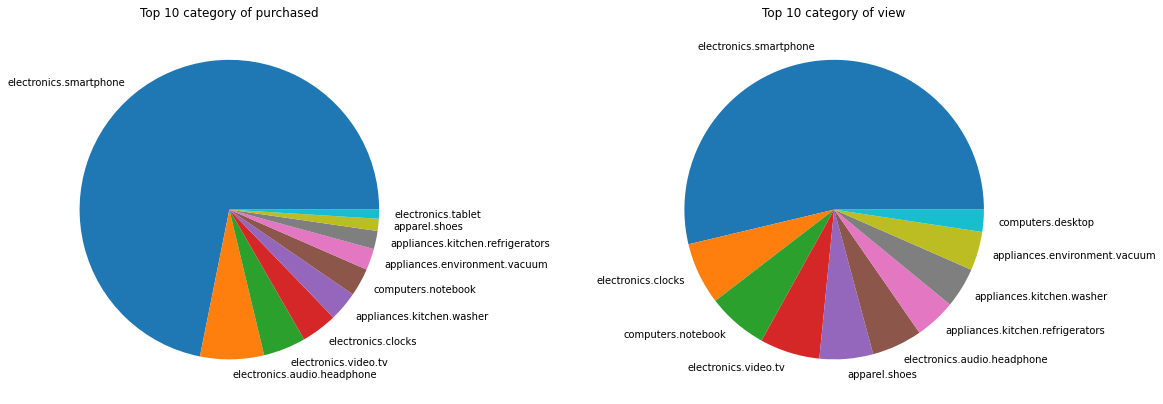

In [6]:
# category that customer purchased
purchased = df.loc[df.event_type == 'purchase']
purchases_category = purchased.loc[purchased.category_code.notnull()]

purchases_top_category = purchases_category.groupby('category_code').category_code.agg([len]).sort_values(by="len", ascending=False)
purchases_top_category.reset_index(inplace=True)
purchases_top_category.rename(columns={"len" : "# sales"}, inplace=True)

# category that customer view
view = df.loc[df.event_type == 'view']
view_category = view.loc[view.category_code.notnull()]

view_top_category = view_category.groupby('category_code').category_code.agg([len]).sort_values(by="len", ascending=False)
view_top_category.reset_index(inplace=True)
view_top_category.rename(columns={"len" : "# sales"}, inplace=True)

# Visualization
fig = plt.figure()

ax1 = fig.add_axes([0, 0, 1.3, 1.3], aspect=1)
ax1.pie(purchases_top_category["# sales"].head(10),labels=purchases_top_category["category_code"].head(10))

ax2 = fig.add_axes([1.4, .0, 1.3, 1.3], aspect=1)
ax2.pie(view_top_category["# sales"].head(10),labels=view_top_category["category_code"].head(10))

ax1.set_title('Top 10 category of purchased')
ax2.set_title('Top 10 category of view')
plt.show()

# Customer purchased activities in Nov

In [7]:
#creating a customer table

#Filtering sales activities
sales_filter = df['event_type']=='purchase'
Customer_table = df.loc[sales_filter].groupby(by=['user_id']).agg(number_of_purchases=
                                                                  ('user_id','count'),total_sales=('price','sum')).reset_index()

In [8]:
#Calculating number of customers who bought something
customers_who_bought_smt = Customer_table['user_id'].nunique()
print('There are {:,.0f} customers, who purchased in Nov.'.format(customers_who_bought_smt))

#Calculationg repeat customers number
more_than_one_purchase_filter = Customer_table['number_of_purchases']>1
customers_who_bought_more_than_once = Customer_table.loc[more_than_one_purchase_filter].shape[0]
print('There are {:,.0f} repeat customers, who bought more than once.'.format(customers_who_bought_more_than_once))

There are 91,226 customers, who purchased in Nov.
There are 25,387 repeat customers, who bought more than once.


### Top 10 users with most puchased activities

In [9]:
customers_with_highest_number_of_purchases = df[sales_filter]
customers_with_highest_number_of_purchases['user_id'].value_counts().head(10)

564068124    319
549109608     54
564769842     53
551801600     50
535327520     50
515644853     49
566195962     48
563889375     47
564133858     46
551140089     45
Name: user_id, dtype: int64

In [10]:
users_activities = df['user_id'] == 551140089
df[users_activities]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
4728909,2019-11-04 04:05:57 UTC,view,11000156,2053013554960793975,appliances.kitchen.toster,smeg,181.52,551140089,300f78c1-4a32-400a-b785-617f5bf09375
4729215,2019-11-04 04:06:11 UTC,view,11000157,2053013554960793975,appliances.kitchen.toster,smeg,181.52,551140089,300f78c1-4a32-400a-b785-617f5bf09375
4729720,2019-11-04 04:06:34 UTC,view,1004249,2053013555631882655,electronics.smartphone,apple,724.60,551140089,300f78c1-4a32-400a-b785-617f5bf09375
4730419,2019-11-04 04:07:06 UTC,cart,1004249,2053013555631882655,electronics.smartphone,apple,724.60,551140089,300f78c1-4a32-400a-b785-617f5bf09375
4732646,2019-11-04 04:08:51 UTC,purchase,1004249,2053013555631882655,electronics.smartphone,apple,724.60,551140089,300f78c1-4a32-400a-b785-617f5bf09375
...,...,...,...,...,...,...,...,...,...
8679633,2019-11-06 09:39:21 UTC,purchase,1004246,2053013555631882655,electronics.smartphone,apple,758.63,551140089,fdf6dcfa-2346-4f04-97a3-89689d6b455e
8680287,2019-11-06 09:39:46 UTC,view,1004246,2053013555631882655,electronics.smartphone,apple,758.63,551140089,fdf6dcfa-2346-4f04-97a3-89689d6b455e
8682710,2019-11-06 09:41:19 UTC,view,4100232,2053013561218695907,NaN,sony,592.01,551140089,fdf6dcfa-2346-4f04-97a3-89689d6b455e
8683557,2019-11-06 09:41:52 UTC,purchase,4100232,2053013561218695907,NaN,sony,592.01,551140089,fdf6dcfa-2346-4f04-97a3-89689d6b455e


# Predict if user will purchase a product

In [18]:
df_targets = df.drop_duplicates(subset=['event_type', 'product_id','price', 'user_id','user_session'])
df_targets["purchased"] = np.where(df_targets["event_type"]=="purchase",1,0)

df_targets["purchased"] = df_targets.groupby(["user_session","product_id"])["purchased"].transform("max")
df_targets = df_targets.loc[df_targets["event_type"]=="cart"].drop_duplicates(["user_session","product_id","purchased"])

df_targets['event_weekday'] = df_targets['event_time'].apply(lambda s: str(datetime.strptime(str(s)[0:10], "%Y-%m-%d").weekday()))
df_targets.dropna(how='any', inplace=True)

df_targets["category_code_level1"] = df_targets["category_code"].str.split(".",expand=True)[0].astype('category')
df_targets["category_code_level2"] = df_targets["category_code"].str.split(".",expand=True)[1].astype('category')

C:\Users\zbbxh\AppData\Local\Temp\ipykernel_15756\242273025.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_targets["purchased"] = np.where(df_targets["event_type"]=="purchase",1,0)
C:\Users\zbbxh\AppData\Local\Temp\ipykernel_15756\242273025.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_targets["purchased"] = df_targets.groupby(["user_session","product_id"])["purchased"].transform("max")


In [19]:
cart_purchase_users = df.loc[df["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['user_id'])
cart_purchase_users.dropna(how='any', inplace=True)
cart_purchase_users_all_activity = df.loc[df['user_id'].isin(cart_purchase_users['user_id'])]

In [20]:
activity_in_session = cart_purchase_users_all_activity.groupby(['user_session'])['event_type'].count().reset_index()
activity_in_session = activity_in_session.rename(columns={"event_type": "activity_count"})

In [21]:
df_targets = df_targets.merge(activity_in_session, on='user_session', how='left')
df_targets['activity_count'] = df_targets['activity_count'].fillna(0)
df_targets.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,purchased,event_weekday,category_code_level1,category_code_level2,activity_count
0,2019-11-01 00:00:14 UTC,cart,1005014,2053013555631882655,electronics.smartphone,samsung,503.09,533326659,6b928be2-2bce-4640-8296-0efdf2fda22a,0,4,electronics,smartphone,1.0
1,2019-11-01 00:03:24 UTC,cart,1801881,2053013554415534427,electronics.video.tv,samsung,488.80,557746614,4d76d6d3-fff5-4880-8327-e9e57b618e0e,1,4,electronics,video,25.0
2,2019-11-01 00:03:39 UTC,cart,1005115,2053013555631882655,electronics.smartphone,apple,949.47,565865924,fd4bd6d4-bd14-4fdc-9aff-bd41a594f82e,0,4,electronics,smartphone,2.0
3,2019-11-01 00:05:54 UTC,cart,1002542,2053013555631882655,electronics.smartphone,apple,486.80,549256216,dcbdc6e4-cd49-4ee8-95c5-e85f3c618fa1,0,4,electronics,smartphone,14.0
4,2019-11-01 00:06:38 UTC,cart,1004856,2053013555631882655,electronics.smartphone,samsung,128.42,513645631,61ceaf50-820a-4858-9a68-bab804d47a22,1,4,electronics,smartphone,9.0


In [22]:
purcahase_set = df_targets[df_targets['purchased']== 1]
purcahase_set.shape[0]

39699

In [23]:
not_purcahase_set = df_targets[df_targets['purchased']== 0]
not_purcahase_set.shape[0]

33357

In [28]:
n_samples = 10000
is_purchase_downsampled = resample(purcahase_set,
                                replace = False, 
                                n_samples = n_samples,
                                random_state = 27)
not_purcahase_set_downsampled = resample(not_purcahase_set,
                                replace = False,
                                n_samples = n_samples,
                                random_state = 27)

In [30]:
downsampled = pd.concat([is_purchase_downsampled, not_purcahase_set_downsampled])
downsampled['purchased'].value_counts()

1    10000
0    10000
Name: purchased, dtype: int64

In [31]:
selected_features = downsampled.loc[:,['brand', 'price', 'event_weekday', 'category_code_level1', 'category_code_level2', 'activity_count']]

In [35]:
selected_features.loc[:,'brand'] = LabelEncoder().fit_transform(downsampled.loc[:,'brand'].copy())
selected_features.loc[:,'event_weekday'] = LabelEncoder().fit_transform(downsampled.loc[:,'event_weekday'].copy())
selected_features.loc[:,'category_code_level1'] = LabelEncoder().fit_transform(downsampled.loc[:,'category_code_level1'].copy())
selected_features.loc[:,'category_code_level2'] = LabelEncoder().fit_transform(downsampled.loc[:,'category_code_level2'].copy())

purchased = LabelEncoder().fit_transform(downsampled['purchased'])
selected_features.head()

C:\Users\zbbxh\AppData\Local\Temp\ipykernel_15756\1940651499.py:1: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  selected_features.loc[:,'brand'] = LabelEncoder().fit_transform(downsampled.loc[:,'brand'].copy())
C:\Users\zbbxh\AppData\Local\Temp\ipykernel_15756\1940651499.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  selected_features.loc[:,'event_weekday'] = LabelEncoder().fit_transform(downsampled.loc[:,'event_weekday'].copy())
C:\Users\zbbxh\AppData\Local\Temp\ipykernel_15756\1940651499.py:3: FutureWarning: In a future version, `df.iloc[:, i

,brand,price,event_weekday,category_code_level1,category_code_level2,activity_count
60686,65,153.89,2,7,24,17.0
29944,133,195.01,6,7,24,17.0
12608,0,283.08,5,4,18,6.0
51163,7,980.31,1,7,24,4.0
66759,7,160.36,2,7,1,4.0


In [36]:

X_train, X_test, y_train, y_test = train_test_split(selected_features, purchased, test_size=0.2, random_state=45)

print('Lenght of our Training data:', X_train.shape, '\nLength of our Testing data:', X_test.shape)


Lenght of our Training data: (16000, 6) 
Length of our Testing data: (4000, 6)


In [37]:
# Initalize our model.  
# This will create an empty untrained Logistic Regression model.
model = LogisticRegression()

model.fit(X_train, y_train)

LogisticRegression()

In [38]:
# Make new predicitions
y_pred = model.predict(X_test)

In [41]:
print("Accuracy:",accuracy_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))

Accuracy: 0.53625
Precision: 0.528006267136702
Recall: 0.6746746746746747


true-negitive: 797 
false-positive: 1205 
false-negative: 650 
true-positive: 1348


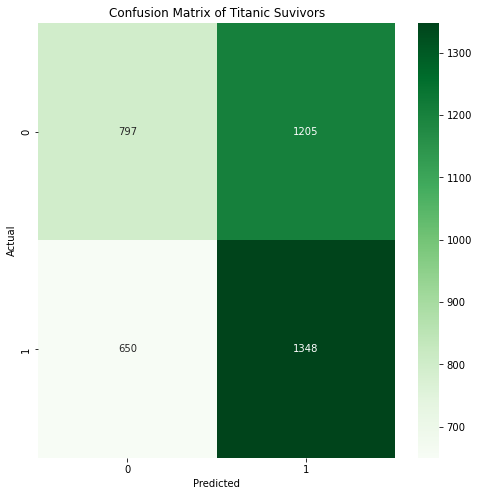

In [42]:
cm = confusion_matrix(y_test, y_pred)

# Just rounding them so the numbers are easier to read
cm = cm.round(2)


tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

fig = plt.figure(figsize=(8,8))
ax = sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')
plt.title("Confusion Matrix of Titanic Suvivors")
plt.xlabel('Predicted')
plt.ylabel('Actual')

print('true-negitive:', tn, 
      '\nfalse-positive:', fp, 
      '\nfalse-negative:', fn, 
      '\ntrue-positive:', tp )

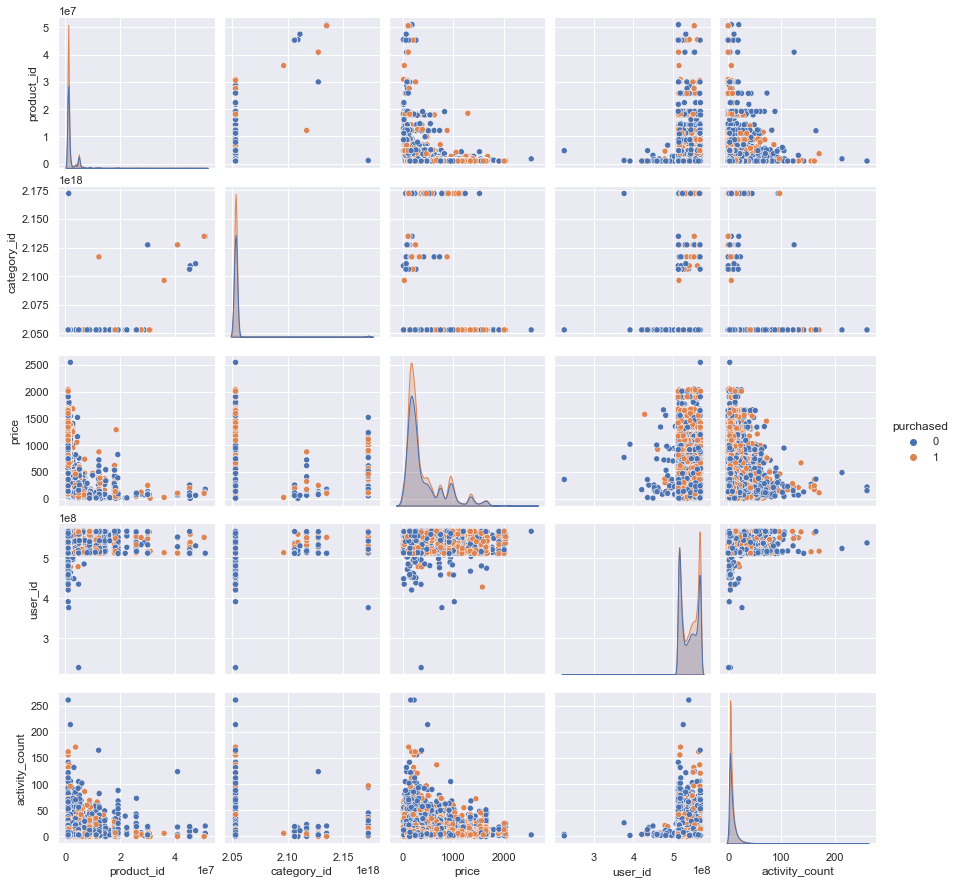

In [47]:
# Seaborn / matplotlib for visualization 
import seaborn as sns
sns.set()

sns.pairplot(df_targets, hue='purchased');